In [67]:
import json
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from tree_registration_and_matching.constants import DATA_DIR
from tree_registration_and_matching.eval import obj_mee_matching
from tree_registration_and_matching.register_MEE import align_plot

# Define constants

In [68]:
# This dataset can be changed to select a different example
DATASET = "0061_000333_000335"

DETECTED_TREES = Path(DATA_DIR, "ofo-tree-registration", "detected-trees.gpkg")
FIELD_TREES = Path(DATA_DIR, "ofo-tree-registration", "field_trees.gpkg")
PLOTS_FILE = Path(DATA_DIR, "ofo-tree-registration", "plot_bounds.gpkg")
SHIFTS_FILE = Path(DATA_DIR, "ofo-tree-registration", "shifts_per_dataset.json")

# This is a scalar multiple of the height to control the point size while plotting
HEIGHT_PLOTTING_SCALE = 0.25

In [69]:
# Read the data
all_preds = gpd.read_file(DETECTED_TREES)
all_field_trees = gpd.read_file(FIELD_TREES)
all_plots = gpd.read_file(PLOTS_FILE)

# Subset to the chosen plot
preds = all_preds.query("dataset_id == @DATASET")
field_trees = all_field_trees.query("dataset_id == @DATASET")
plots = all_plots.query("dataset_id == @DATASET")

# And convert the CRS
field_trees.to_crs(preds.crs, inplace=True)
plots.to_crs(preds.crs, inplace=True)

# Read the shifts
with open(SHIFTS_FILE) as infile:
    data = json.load(infile)
shift = data[DATASET][0]

/home/exouser/miniconda3/envs/TRAM-dev/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Introduce error
The data is provided in a registered form. Reintroduce the original translation error.

In [70]:
field_trees.geometry = field_trees.translate(xoff=-shift[0], yoff=-shift[1])
plots.geometry = plots.translate(xoff=-shift[0], yoff=-shift[1])

# Plot the data
This shows the data with the initial erronous shift. Both detected and field trees are sized according to the corresponding height.

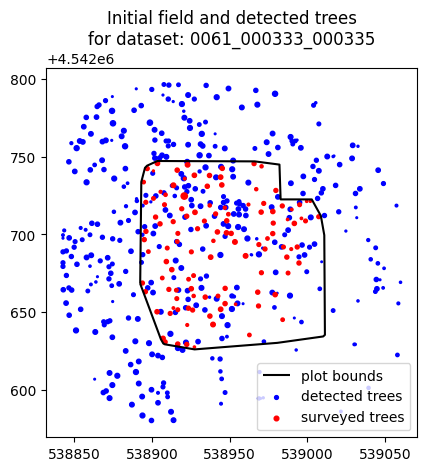

In [71]:
f, ax = plt.subplots()
plots.boundary.plot(ax=ax, color="k", markersize=2, label="plot bounds")
preds.plot(
    ax=ax,
    c="b",
    markersize=preds["height"] * HEIGHT_PLOTTING_SCALE,
    label="detected trees",
)
field_trees.plot(
    ax=ax,
    c="r",
    markersize=field_trees["height"] * HEIGHT_PLOTTING_SCALE,
    label="surveyed trees",
)
ax.legend()
plt.title(f"Initial field and detected trees\nfor dataset: {DATASET}")
plt.show()

## Registration
Run registration between the two datasets. This particular algorithm tries a variety of candidate shifts between the two datasets and computes a quality metric for the alignment at each one. Specifically, it computes the number of trees that satisfy specific matching condidtions. The visualization shows the quality of alignment for each of the attempted shifts.

/home/exouser/miniconda3/envs/TRAM-dev/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


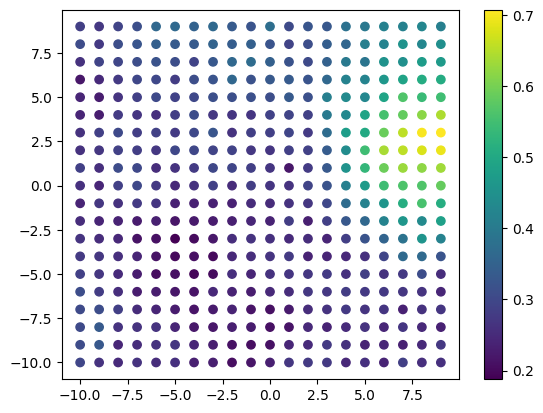

Rough shift: (np.int64(9), np.int64(3)), fine shift: (np.float64(8.600000000000001), np.float64(2.3999999999999995))


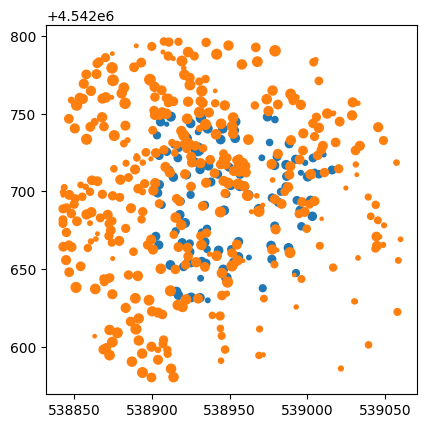

Estimated shift: (np.float64(8.600000000000001), np.float64(2.3999999999999995))
Difference between optimal and estimated shift: [ 0.00187817 -0.90978001]


In [72]:
estimated_shift, shifted_field_trees = align_plot(
    field_trees=field_trees, drone_trees=preds, obs_bounds=plots, vis=True
)
print(f"Estimated shift: {estimated_shift}")
print(
    f"Difference between optimal and estimated shift: {np.array(shift) - np.array(estimated_shift)}"
)

## Plot the shifted trees
This plot is similar to the first tree-level plot except that it shows the field trees after the estimated shift has been applied.

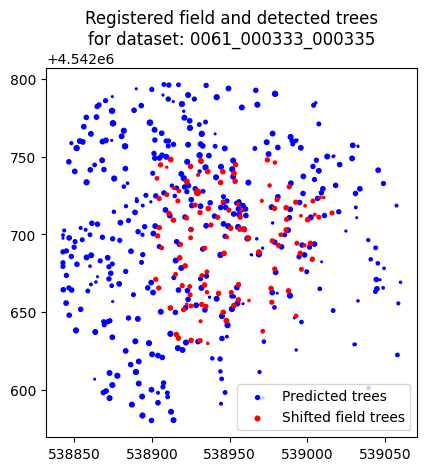

In [73]:
f, ax = plt.subplots(1, 1)
preds.plot(
    ax=ax,
    color="blue",
    markersize=preds["height"] * HEIGHT_PLOTTING_SCALE,
    label="Predicted trees",
)
shifted_field_trees.plot(
    ax=ax,
    color="red",
    markersize=shifted_field_trees["height"] * HEIGHT_PLOTTING_SCALE,
    label="Shifted field trees",
)
plt.title(f"Registered field and detected trees\nfor dataset: {DATASET}")
ax.legend()
plt.show()

## Scoring
This computes the F1 score using the definition used in this paper: https://besjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/2041-210X.13860. 

In [74]:
F1_score = obj_mee_matching(
    shifted_field_trees=shifted_field_trees, drone_trees=preds, obs_bounds=plots
)
print(f"F1 score {F1_score}")

F1 score 0.725028376844495
